In [1]:
!pip install pandas scikit-learn optuna seaborn statsmodels

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import optuna
import os
from include.utils import incrementar_dados_aleatorios_csv, categorizar_imc
from include.utils import prever_encargos_futuros, segmentacao_de_risco, analise_de_sensibilidade, otimizacao_de_recursos, planejamento_estrategico

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

dados = pd.read_csv('../planilhas/2_dados_aleatorios_sobre_original.csv', encoding='latin-1')

# Aplicar a função para categorizar IMC e criar uma nova coluna 'Categoria IMC'
dados['Categoria IMC'] = dados['IMC'].apply(categorizar_imc)

print(dados)

      Idade     Gênero    IMC  Filhos Fumante    Região  Encargos  \
0      56.0   feminino  29.77     2.0     sim  sudoeste  31109.89   
1      46.0  masculino  25.86     1.0     não  nordeste  26650.70   
2      32.0  masculino  23.01     0.0     não  sudoeste  21459.04   
3      39.0   feminino  28.54     2.0     não   sudeste  29996.29   
4      45.0  masculino  22.26     2.0     sim  noroeste  31594.72   
...     ...        ...    ...     ...     ...       ...       ...   
1998   39.0   feminino  24.72     2.0     sim   sudeste  28482.43   
1999   68.0   feminino  21.66     1.0     sim  sudoeste  38822.71   
2000   61.0   feminino  19.49     2.0     sim  nordeste  38162.29   
2001   53.0  masculino  34.78     1.0     sim   sudeste  30091.75   
2002    NaN        NaN    NaN     NaN     NaN       NaN       NaN   

       Categoria IMC  
0          Sobrepeso  
1          Sobrepeso  
2        Peso normal  
3          Sobrepeso  
4        Peso normal  
...              ...  
1998     P

In [5]:
# Mapeamento das regiões para valores numéricos
regiao_numerica = {'sudoeste': 1, 'sudeste': 2, 'nordeste': 3, 'noroeste': 4}

# Convertendo os valores da coluna 'Região' para valores numéricos usando o mapeamento
dados['Região_numerica'] = dados['Região'].map(regiao_numerica)

**2. Limpeza de Dados**

In [6]:
# Remover linhas com valores NaN
dados = dados.dropna()

# Substituir valores nulos por zero
dados['Filhos'] = dados['Filhos'].fillna(0)
dados['Filhos'] = dados['Filhos'].astype(int)
dados['Idade'] = dados['Idade'].fillna(0)
dados['Idade'] = dados['Idade'].astype(int)
dados['Encargos'] = dados['Encargos'].fillna(0)

dados['Gênero'] = dados['Gênero'].str.replace('nan', 'Não informado')

**3. Pré-processamento**

In [7]:
# Dividir os dados em features (X) e target (y)
X = dados.drop('Encargos', axis=1)  # descartando colunas não necessárias para o teste
y = dados['Encargos']

# Codificar variáveis categóricas usando one-hot encoding
colunas_codificadas_via_one_hot = ['Gênero', 'Região']
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X[colunas_codificadas_via_one_hot])

# Concatenar features codificadas com as restantes
X_encoded = pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out(colunas_codificadas_via_one_hot), index=X.index)
X = pd.concat([X.drop(colunas_codificadas_via_one_hot, axis=1), X_encoded], axis=1)

# Codificar variável categórica 'IMC' com LabelEncoder
label_encoder = LabelEncoder()
X['Categoria IMC'] = label_encoder.fit_transform(X['Categoria IMC'])

# Substituir valores 'sim' e 'não' por 1 e 0
X['Fumante'] = X['Fumante'].map({'sim': 1, 'não': 0})

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [8]:
# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Calcular a matriz de correlação dos dados de treinamento
correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
                     Idade       IMC    Filhos   Fumante  Categoria IMC  \
Idade             1.000000  0.039183  0.000045 -0.003769      -0.052839   
IMC               0.039183  1.000000 -0.054940  0.000288      -0.288376   
Filhos            0.000045 -0.054940  1.000000 -0.043190       0.016010   
Fumante          -0.003769  0.000288 -0.043190  1.000000      -0.030890   
Categoria IMC    -0.052839 -0.288376  0.016010 -0.030890       1.000000   
Região_numerica  -0.029334 -0.028151  0.015860  0.027000      -0.055491   
Gênero_masculino  0.016950  0.015223 -0.023022  0.012767      -0.018499   
Região_noroeste  -0.024409 -0.006173 -0.011653  0.042747      -0.078787   
Região_sudeste    0.017327 -0.013235 -0.005903 -0.027553       0.027459   
Região_sudoeste   0.017272  0.039930 -0.023609  0.000047       0.018776   

                  Região_numerica  Gênero_masculino  Região_noroeste  \
Idade                   -0.029334          0.016950        -0.02440

**Validação estatística**

Utilizando métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança):            

In [9]:
dados_aux = dados.copy()

dados_aux['Fumante'] = dados_aux['Fumante'].map({'sim': 1, 'não': 0})

# Adicione uma coluna de intercepto aos dados
dados_aux['Intercepto'] = 1

# Dividindo os dados em variáveis independentes (X) e variável dependente (y)
X = dados_aux[['Idade', 'Filhos', 'Fumante']]
y = dados_aux['Encargos']

# Ajustando o modelo de regressão linear usando OLS (Ordinary Least Squares)
modelo = sm.OLS(y, X).fit()

# Calculando os p-values dos coeficientes
p_values = modelo.summary2().tables[1]['P>|t|']

# Calculando os intervalos de confiança dos coeficientes
conf_intervals = modelo.conf_int()

# Imprima os resultados
print("P-values dos coeficientes:")
print(p_values)
print("\nIntervalos de Confiança dos coeficientes:")
print(round(conf_intervals,2))

P-values dos coeficientes:
Idade      0.000000e+00
Filhos     1.396528e-55
Fumante    9.612381e-22
Name: P>|t|, dtype: float64

Intervalos de Confiança dos coeficientes:
               0        1
Idade     566.40   575.83
Filhos    846.37  1078.53
Fumante  1059.78  1596.56


**4. Treinamento do Modelo**

In [10]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Treinamento e avaliação dos modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    print(f'{name} MSE: {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'Acurácia média com validação cruzada para {name}: {round(scores.mean(),2)}')
    
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, LinearRegression):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"Coeficientes das características para {name}:")
        print(round(importance_df,2))
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"Importância das características para {name}:")
        print(round(importance_df,2))
    else:
        print(f"Não é possível calcular a importância das características para o modelo {name}")

--------------------------------------------------------------------------------------------------------------------------------------------------------------
Random Forest Regressor MSE: 7348303.42
Acurácia média com validação cruzada para Random Forest Regressor: 0.91
Importância das características para Random Forest Regressor:
            Colunas  Importância
0             Idade         0.93
1               IMC         0.04
2            Filhos         0.01
5   Região_numerica         0.01
6  Gênero_masculino         0.00
3           Fumante         0.00
4     Categoria IMC         0.00
8    Região_sudeste         0.00
7   Região_noroeste         0.00
9   Região_sudoeste         0.00
--------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear Regression MSE: 6463940.65
Acurácia média com validação cruzada para Linear Regression: 0.92
Coeficientes das características para Linear 

**5. Comparação de Modelos**

In [11]:
# Seleção de modelo com base na menor pontuação de validação cruzada
best_model_name = min(models, key=lambda model: cross_val_score(models[model], X_train, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [12]:
best_model = models[best_model_name]
print(f'Best Model: {best_model_name}')

Best Model: Support Vector Regression


**7. Otimização de Modelo**

In [13]:
# Otimização de hiperparâmetros com Optuna (exemplo com RandomForestRegressor)
def objective(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_int('n_estimators', 10, 100)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_int('max_depth', 2, 32)
        model = DecisionTreeRegressor(max_depth=max_depth)
    else:
        model = models[best_model_name]  # Use the default hyperparameters for other models
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-10 00:05:59,076] A new study created in memory with name: no-name-1868e52d-9bb3-46e8-83cd-0939e6d89714
[I 2024-04-10 00:06:01,565] Trial 0 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:04,423] Trial 1 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:08,332] Trial 2 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:08,612] Trial 3 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:08,881] Trial 4 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:09,181] Trial 5 finished with value: -83058087.75647253 and parameters: {}. Best is trial 0 with value: -83058087.75647253.
[I 2024-04-10 00:06:09

In [14]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Optimized {best_model_name} MSE: {round(mse,2)}')

Optimized Support Vector Regression MSE: 87402190.0


In [15]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")

O modelo selecionado não suporta o cálculo de importância das características.


In [16]:
# Definição de dados futuros - 100 linhas
dados_futuros = pd.DataFrame(np.random.rand(200, len(X_train.columns)), columns=X_train.columns)
print(dados_futuros.head())

      Idade       IMC    Filhos   Fumante  Categoria IMC  Região_numerica  \
0  0.226565  0.929435  0.261265  0.724007       0.372665         0.865353   
1  0.189496  0.275955  0.109003  0.004453       0.208316         0.670130   
2  0.847513  0.006761  0.464334  0.790285       0.375507         0.386387   
3  0.563451  0.863900  0.678386  0.480290       0.507057         0.099243   
4  0.658063  0.203220  0.664274  0.660385       0.805154         0.602796   

   Gênero_masculino  Região_noroeste  Região_sudeste  Região_sudoeste  
0          0.084143         0.039119        0.488872         0.697382  
1          0.685971         0.412151        0.078552         0.197247  
2          0.460023         0.336966        0.026452         0.780691  
3          0.360456         0.881579        0.611603         0.002289  
4          0.859740         0.305271        0.169527         0.848114  


Modelo treinado para fazer previsões dos encargos futuros:

In [17]:
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros)

Grupos de indivíduos com diferentes níveis de risco

In [18]:
grupos_risco = segmentacao_de_risco(best_model, dados_futuros)

Análises de sensibilidade para entender o impacto das mudanças nas características dos segurados nos encargos previstos:

In [19]:
custos_previstos_alterados = analise_de_sensibilidade(best_model, dados_futuros, 'Idade', novo_valor=40)

Utilizando as previsões dos encargos para otimizar a alocação de recursos:

In [20]:
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos:

In [21]:
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros)

In [22]:
# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargo Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Recursos Otimizados'] = custos_previstos_alterados
dados_futuros['Planos estratégicos'] = planos_estrategicos
dados_futuros['Encargos'] = np.nan

# Salvar os dados randômicos futuros
dados_futuros.to_csv("../planilhas/4_dados_futuros.csv", index=False, encoding='latin1')

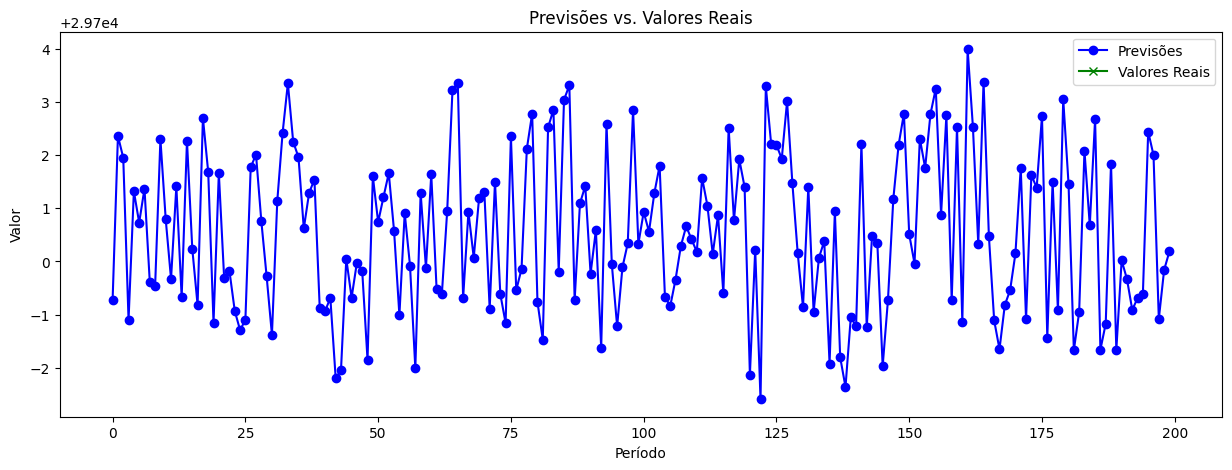

In [23]:
fig, axs = plt.subplots(figsize=(15, 5))

# Criar gráfico
plt.plot(dados_futuros['Encargo Futuro'], label='Previsões', color='blue', marker='o')
plt.plot(dados_futuros['Encargos'], label='Valores Reais', color='green', marker='x')

# Adicionar rótulos e legenda
plt.xlabel('Período')
plt.ylabel('Valor')
plt.legend()

# Exibir gráfico
plt.title('Previsões vs. Valores Reais')
plt.show()